# Пакеты прикладных программ, задание №2

С сайта Центрального банка РФ взять данные по финансовым показателям за несколько лет, загрузить в DataFrame в Pandas. Средствами пакета Sklearn посчитать скользящие регрессии с окном одних показателей на другие. Попробовать разные окна, оценить остатки.

__Теоретическое описание алгоритма__

Скользящая регрессия состоит в следующем. Пусть имеется две выборки $X$ и $Y$ объема $N$. Параметром алгоритма является окно $window < N$. Для каждого $t$ от $0$ до $N$ - window рассмотрим подвыборки $X[t, t + window]$ и $Y[t, t + window]$ и посчитаем для них линейную регрессию. Получим коэффициенты $ \alpha(t) $ и $ \beta(t) $ - функции от $ t $. Вид этих функций и позволяет выяснить, коррелируют ли выборки $X$ и $Y$: если эти функции близки к линейным, то выборки коррелируют.

__Реализация__

Были взяты данные с сайта cbr.ru, иллюстрирующие колебание курса следующих валют (относительно российского рубля):
    - польский злотый,
    - болгарский лев,
    - китайский юань,
    - японская иена;
с 23.03.2015 по 22.03.2019. Соответствующие им файлы были названы 0.csv, 1.csv, 2.csv, 3.csv.

Следующий код позволяет объединить эти файлы в одну базу final.csv.

In [1]:
# -*- coding: utf-8 -*-
import csv

input_files = []
rdrs = []
keys = []
first_rows = []
n = 4

output_file = open("final.csv", "w")
wrtr = csv.writer(output_file)

for i in range(n):
    if i < 10:
        input_files.append(open(chr(i+ord("0"))+".csv"))
    else:
        input_files.append(open("1"+chr(i-10+ord("0"))+".csv"))
    rdrs.append(csv.reader(input_files[-1]))
    keys.append(next(rdrs[-1]))
    if 0 == i:
        curs_indx = keys[-1].index("curs")
        cdx_indx = keys[-1].index("cdx")
        nominal_indx = keys[-1].index("nominal")
        data_indx = keys[-1].index("data")
    first_rows.append(next(rdrs[-1]))
    
new_keys = ["Дата", ]
for i in range(n):
    new_keys.append(first_rows[i][cdx_indx])
    
wrtr.writerow(new_keys)

for i in range(n):
    if 0 == i:
        new_row = [str(first_rows[i][data_indx]),]
    new_row.append(str(float(first_rows[i][curs_indx]) / \
                       float(first_rows[i][nominal_indx])))
wrtr.writerow(new_row)

global_data = [[],]

for i in range(n):
    global_data.append([])
    for row in rdrs[i]:
        if 0 == i:
            global_data[i].append(row[data_indx])
        global_data[i+1].append(str(float(row[curs_indx]) / \
                                    float(row[nominal_indx])))

global_data = map(list, zip(*global_data))

for row in global_data:
    wrtr.writerow(row)
    
output_file.close()

Загрузим теперь эту базу в Dataframe в Pandas.

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv("final.csv", encoding='cp1251', index_col="Дата")

Опишем теперь функцию, реализующую скользящую регрессию, а также строящую линейную функцию $ \hat{y}[t, t + window]=\alpha(t)x[t, t + window] + \beta(t) $ и считающую остаток $ error(t) = \left|y[t, t + window] - \hat{y}[t, t + window]\right| $.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def rolling_regr(X_vect, y_vect, maping, colormap, window=255):

    assert len(X_vect)==len(y_vect)
    
    alphas = []
    betas = []
    errors = []

    model_ols = LinearRegression()

    for i_start in range(len(X_vect) - window):        
        i_end = i_start + window

        X_curr = X_vect[i_start : i_end].values.reshape(-1, 1)
        y_curr = y_vect[i_start : i_end].values.reshape(-1, 1)

        model_ols.fit(X_curr, y_curr)
        
        alphas.append(model_ols.coef_)
        betas.append(model_ols.intercept_)
        
        y_predict = model_ols.intercept_ + model_ols.coef_[0] * X_vect
        
        plt.plot(X_vect, y_predict, alpha=0.4, color=maping(colormap[i_end]), linewidth=1)
        
        errors.append(mean_absolute_error(y_vect[i_start : i_end], y_predict[i_start : i_end]))

    return alphas, betas, errors

Опишем теперь функцию, которая будет принимать на вход названия валют и размер окна, а на выходе строит точки $(x,y)$ по всем возможным датам, все посчитанные $ \hat{y} $, а также функции $\alpha(t)$ и $\beta(t)$.

In [5]:
from datetime import datetime

def plotting(value_1, value_2, window):

    N = data.shape[0]

    X_vect = data[value_1][:N]
    y_vect = data[value_2][:N]

    colormap = np.linspace(0, 1, N)
    maping = plt.get_cmap()
    scat = plt.scatter(X_vect, y_vect, c=colormap, cmap=maping, linewidth=0)
    cbar = plt.colorbar(scat)
    cbar.ax.set_yticklabels(data[::N // 5].index)

    alphas, betas, errors = rolling_regr(X_vect, y_vect, maping, colormap, window)

    plt.xlabel(value_1)
    plt.ylabel(value_2)
    
    plt.grid()
    plt.show()

    alphas = np.array(alphas).flatten()
    betas = np.array(betas).flatten()
    errors = np.array(errors).flatten()

    error_0 = np.mean(errors)
    print("Error: ", error_0)

    format_str = '%m/%d/%Y'
    dates = np.array([datetime.strptime(elem, format_str) for elem in data[window : N].index]).flatten()

    plt.plot(dates, alphas)
    plt.xlabel('Дата')
    plt.ylabel(r'$\alpha(t)$')
    plt.xticks(rotation = 45)
    
    plt.grid()
    plt.show()

    plt.plot(dates, betas)
    plt.xlabel('Дата')
    plt.ylabel(r'$\beta(t)$')
    plt.xticks(rotation = 45)
    
    plt.grid()
    plt.show()

Приведём примеры работы программы для различных валют и различных окон.

__Пример №1__

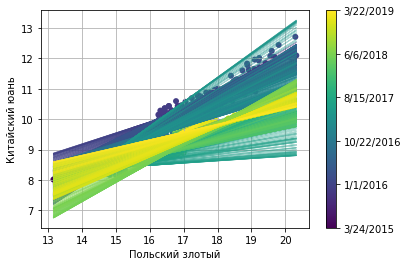

Error:  0.12348410405972071


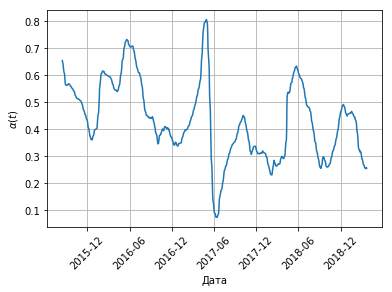

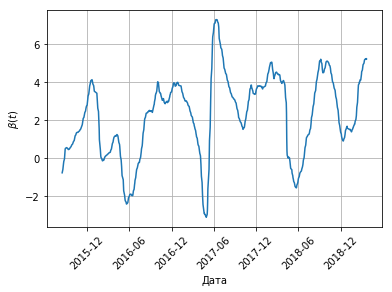

In [6]:
value_1 = "Польский злотый"
value_2 = "Китайский юань"

window = 100

plotting(value_1, value_2, window)

__Пример №2__

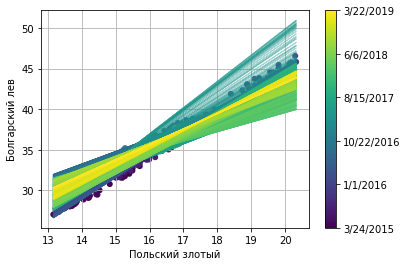

Error:  0.27311367672343584


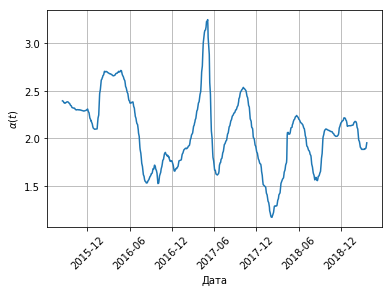

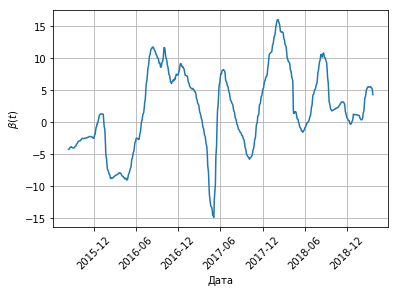

In [8]:
value_1 = "Польский злотый"
value_2 = "Болгарский лев"

window = 100

plotting(value_1, value_2, window)

__Пример №3__

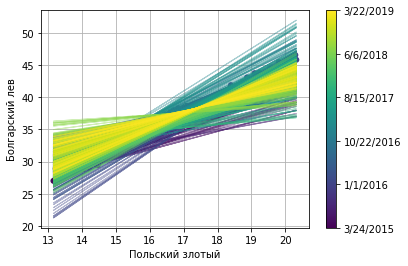

Error:  0.12822934559797608


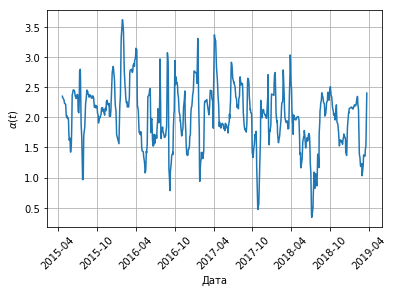

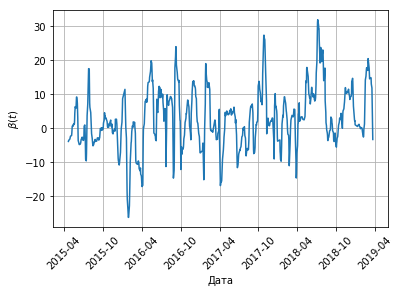

In [9]:
value_1 = "Польский злотый"
value_2 = "Болгарский лев"

window = 20

plotting(value_1, value_2, window)

__Пример №4__

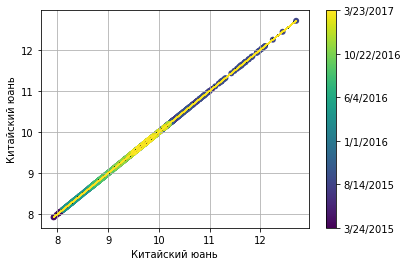

Error:  3.326686211006859e-17


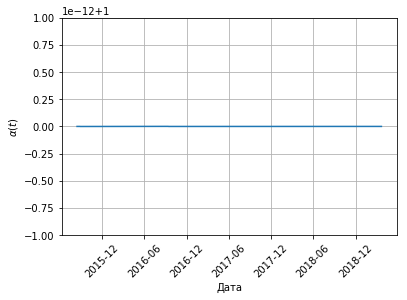

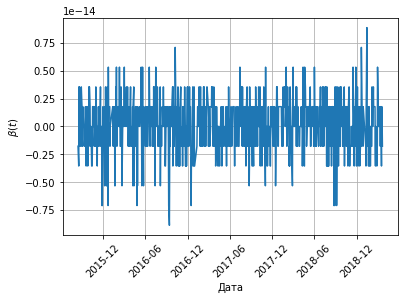

In [36]:
value_1 = "Китайский юань"
value_2 = "Китайский юань"

# проверка случая полной коррелируемости

window = 100

plotting(value_1, value_2, window)

__Пример №5__

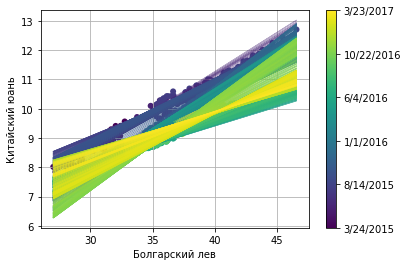

Error:  0.08850948203890396


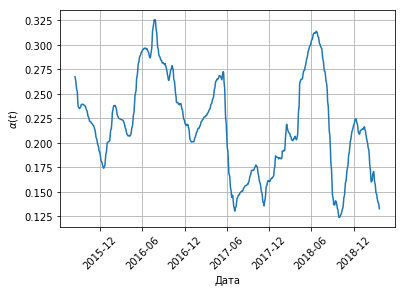

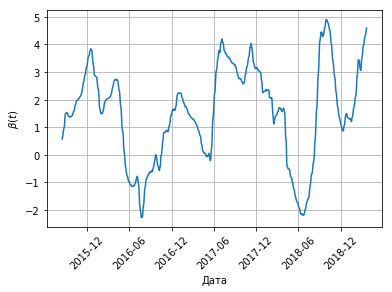

In [37]:
value_1 = "Болгарский лев"
value_2 = "Китайский юань"

window = 500

plotting(value_1, value_2, window)